## Car-price prediction project

Suppose that we have a website where people can sell and buy used cars. <br>
<br>
When posting an ad on our website, the sellers often struggle to come up with a meaningful price. We want to help our users with automatic price recommendation. We ask the sellers to specify model, make, year, mileage, and other important characteristics of a car, and based on that information, we want to suggest the best price.<br>

### Task 00 Import libraryes

In [7]:
import pandas as pd # Import Pandas: a library for tabular data
import numpy as np # Import NumPy: a library for numerical operations

#Import plotting libraries: matplotlib and seaborn
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### Task 01 Downloading the dataset

In [9]:
import requests
url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'
res = requests.get(url, allow_redirects=True)
with open('data.csv','wb') as file:
    file.write(res.content)


### Task 02 Exploratory data analysis

We look at the dataset to learn:
* The distribution of the target variable
* The features in this dataset
* The distribution of values in these features
* The quality of the data
* The number of missing values

In [13]:
# Read the data
df = pd.read_csv('data')

In [14]:
# how many rows are there
len(df)

11914

In [15]:
# Now let’s use df.head() to look at the first five rows of our dataframe
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


__Note__ <br>

We can already see that there are some inconsistencies in this dataset: the column names sometimes have spaces and sometimes
have underscores (_). <br>

This is inconvenient and confusing, <br>
but we can solve this by normalizing them: replace all spaces with underscores and lowercase all letters:

In [16]:
# Lowercase all the column names, and replace spaces with underscores.
df.columns = df.columns.str.lower().str.replace(' ', '_')
# Select only columns with string values.
string_columns = list(df.dtypes[df.dtypes == 'object'].index) 
# Lowercase and replace spaces with underscores for values in all string columns of the dataframe.
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_') 

After this initial preprocessing, the dataframe looks more uniform


In [17]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


__Note__
For us, the most interesting column here is the last one: MSRP (manufacturer’s suggested
retail price, or simply the price of a car). We will use this column for predicting the prices of a
car.

The MSRP column contain the important information — it’s our target variable, the y, which is
the value that we want to learn to predict.

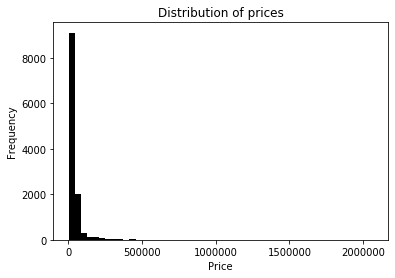

In [20]:
plt.figure(figsize=(6, 4))

sns.distplot(df.msrp, kde=False, hist_kws=dict(color='black', alpha=1))
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

__Note__ <br>
After plotting this graph, we immediately notice that the distribution of prices has a very long
tail. There are many cars with low prices on the left side, but the number quickly drops, and
there’s a long tail of very few cars with high prices

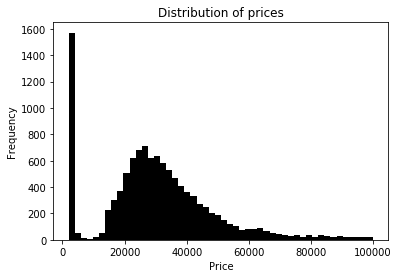

In [21]:
#We can have a closer look by zooming in a bit and looking at values below $100,000
plt.figure(figsize=(6, 4))

sns.distplot(df.msrp[df.msrp < 100000], kde=False, hist_kws=dict(color='black', alpha=1))
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

__Note__
The long tail makes it quite difficult for us to see the distribution, but it has an even stronger
effect on a model: such distribution can greatly confuse the model, so it won’t learn well
enough. One way to solve this problem is log transformation. If we apply the log function to
the prices, it removes the undesired effect 

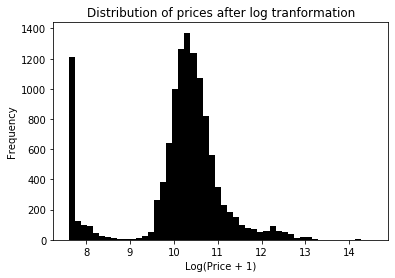

In [22]:
log_price = np.log1p(df.msrp)

plt.figure(figsize=(6, 4))

sns.distplot(log_price, kde=False, hist_kws=dict(color='black', alpha=1))
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Distribution of prices after log tranformation')

plt.show()

__Note__
Generally, it’s good when the target distribution looks like the normal distribution (figure 2.8). Under
this condition, models such as linear regression perform well.

In [23]:
#Checking for missing values
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

#### Validation Framework

In [25]:
n = len(df) #A Get the number of rows in the dataframe.

#B Calculate how many rows should go to train, validation, and test
n_val = int(0.2 * n) #B
n_test = int(0.2 * n) #B
n_train = n - (n_val + n_test) #B


np.random.seed(2) #C Fix the random seed to make sure that the results are reproducible

#D Create a NumPy array with indices from 0 to (n-1) and shuffle it
idx = np.arange(n) #D
np.random.shuffle(idx) #D

df_shuffled = df.iloc[idx] #E Use the array with indices to get a shuffled dataframe.

#F  Split the shuffled dataframe into train, validation, and test
df_train = df_shuffled.iloc[:n_train].copy() #F
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy() #F
df_test = df_shuffled.iloc[n_train+n_val:].copy() #F


Our initial analysis showed a
long tail in the distribution of prices, and to remove its effect, we need to apply the log
transformation. We can do that for each dataframe separately:

In [26]:
y_train_orig = df_train.msrp.values
y_val_orig = df_val.msrp.values
y_test_orig = df_test.msrp.values

y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

#### Linear Regression

Let’s pick a few numerical features and ignore the rest for now. We can start with horsepower,
mpg in the city, and popularity

* engine_hp
* city_mpg
* popularity
* engine_cylinders
* highway_mpg



In [28]:
def linear_regression(X, y):
 # adding the dummy column
 ones = np.ones(X.shape[0]) # A Create an array that contains only 1s.
 X = np.column_stack([ones, X]) # B  Add the array of 1s as the first column of X

 # normal equation formula
 XTX = X.T.dot(X) # C  Compute XTX.
 XTX_inv = np.linalg.inv(XTX) # D Compute the inverse of XTX
 w = XTX_inv.dot(X.T).dot(y) # E Compute the rest of the normal equation.

 return w[0], w[1:] # F  Split the weights vector into the bias and the rest of the weights

__Note__  The function column_stack takes a list of NumPy arrays and stacks them in columns. In our case,
the function appends the array with ones as the first column of the matrix

### Baseline solution


In [29]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']

In [32]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [33]:
X_train = prepare_X(df_train)
w_0, w = linear_regression(X_train, y_train)

In [34]:
#Predict
y_pred = w_0 + X_train.dot(w)

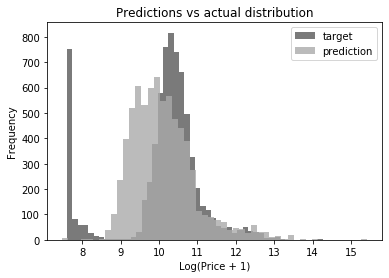

In [35]:
plt.figure(figsize=(6, 4))

sns.distplot(y_train, label='target', kde=False,
             hist_kws=dict(color='#222222', alpha=0.6))
sns.distplot(y_pred, label='prediction', kde=False,
             hist_kws=dict(color='#aaaaaa', alpha=0.8))

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

__Note__
The distribution of values we predicted looks quite
different from the actual values. This result may indicate that the model is not powerful
enough to capture the distribution of the target variable. This shouldn’t be a surprise to us:
the model we used is quite basic and includes only five very simple features.

### RMSE: evaluating model quality

In [36]:
#The implementation of root mean squared error.
def rmse(y, y_pred):
    error = y_pred - y #A Compute the difference between the prediction and the target.
    mse = (error ** 2).mean() #B Compute MSE: first compute the squared error and then calculate its mean.
    return np.sqrt(mse) #C Take the square root to get RMSE.


In [38]:
rmse(y_train, y_pred)

0.7554192603920132

#### Validation the model

In [39]:
X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)

In [40]:
rmse(y_val, y_pred)

0.7616530991301601

#### Simple feature engineering